In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.categorical import Categorical
import gymnasium as gym

In [47]:
class Actor(nn.Module):
    def __init__(self, layer_sizes, activation, output_activation) -> None:
        super().__init__()
        layers = []
        num_of_layers = len(layer_sizes)
        for i in range(num_of_layers - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            activation_function = activation if i < (num_of_layers - 2) else output_activation
            layers += [layer, activation_function()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.model(x)
        return Categorical(logits=logits)

    def update(self, optimizer, loss):
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()


In [48]:
class Critic(nn.Module):
    def __init__(self, layer_sizes, activation, output_activation) -> None:
        super().__init__()
        layers = []
        num_of_layers = len(layer_sizes)
        for i in range(num_of_layers - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            activation_function = activation if i < (num_of_layers - 2) else output_activation
            layers += [layer, activation_function()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def update(self, optimizer, loss):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [49]:
class A2C: 
    def __init__(self, env, actor_lr=1e-3, critic_lr=1e-2, gamma=1) -> None:
        self.env = env
        self.actor = Actor([env.observation_space.shape[0], 256, 256, env.action_space.n], nn.ReLU, nn.Identity)
        self.critic = Critic([env.observation_space.shape[0], 256, 256, 1], nn.ReLU, nn.Identity)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma

    def sample_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        return self.actor(obs).sample().item()

    def compute_actor_loss(self, observations, actions, advantages):
        logp = self.actor(observations).log_prob(actions)
        return -(logp * advantages).mean()
        
    def compute_critic_loss(self, action_values, values):
        return F.mse_loss(action_values, values)
        
    def compute_action_values(self, rewards, gamma, terminal_value):
        action_values = torch.zeros(len(rewards), dtype=torch.float32)
        action_value = terminal_value
        for t in reversed(range(len(rewards))):
            action_value = rewards[t] + gamma * action_value
            action_values[t] = action_value
        return action_values

    def compute_advantage(self, action_values, values):
        return action_values - values

    def train(self, episodes=100):
        returns = torch.zeros(episodes, dtype=torch.float32)
        lengths = torch.zeros(episodes, dtype=torch.float32)
        for episode in range(episodes):
            observations = torch.zeros((self.env.spec.max_episode_steps, self.env.observation_space.shape[0]), dtype=torch.float32)
            actions = torch.zeros(self.env.spec.max_episode_steps, dtype=torch.float32)
            rewards = torch.zeros(self.env.spec.max_episode_steps, dtype=torch.float32)
            values = torch.zeros(self.env.spec.max_episode_steps, dtype=torch.float32)
            obs, info  = self.env.reset()
            obs = torch.as_tensor(obs, dtype=torch.float32) 
            terminated = truncated = False
            t = 0
            while not terminated and not truncated:
                observations[t] = obs
                action = self.sample_action(obs)
                actions[t] = torch.tensor(action, dtype=torch.float32)
                value = self.critic(obs)
                values[t] = value
                obs, reward, terminated, truncated, info = self.env.step(action)
                obs = torch.as_tensor(obs, dtype=torch.float32) 
                rewards[t] = reward
                t += 1    
            observations, actions, rewards, values = observations[:t], actions[:t], rewards[:t], values[:t]
            if torch.isnan(observations).any() or torch.isnan(actions).any() or torch.isnan(values).any():
                raise ValueError("NaN value detected in obs or acts or vals.")
            terminal_value = self.critic(obs)
            action_values = self.compute_action_values(rewards, self.gamma, terminal_value)
            advantages = self.compute_advantage(action_values, values)
            actor_loss = self.compute_actor_loss(observations, actions, advantages)
            critic_loss = self.compute_critic_loss(action_values, values)
            if torch.isnan(actor_loss).any() or torch.isnan(critic_loss).any():
                raise ValueError("NaN value detected in losses.")
            self.actor.update(self.actor_optimizer, actor_loss)
            self.critic.update(self.critic_optimizer, critic_loss)
            returns[episode] = rewards.sum()
            lengths[episode] = len(rewards)
            
            if episode % 100 == 0:
                print(f"Episode: {episode} Return: {rewards.sum()}")
        return returns, lengths

In [50]:
env = gym.make("CartPole-v1")
ac = A2C(env)
returns, lengths = ac.train(episodes=1000)

/var/folders/_z/19yn91c54_9fz4v71cxc8ckh0000gn/T/ipykernel_20727/1732732948.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32)


Episode: 0 Return: 32.0
Episode: 100 Return: 32.0
Episode: 200 Return: 249.0
Episode: 300 Return: 438.0
Episode: 400 Return: 500.0
Episode: 500 Return: 500.0
Episode: 600 Return: 500.0
Episode: 700 Return: 500.0
Episode: 800 Return: 500.0
Episode: 900 Return: 500.0


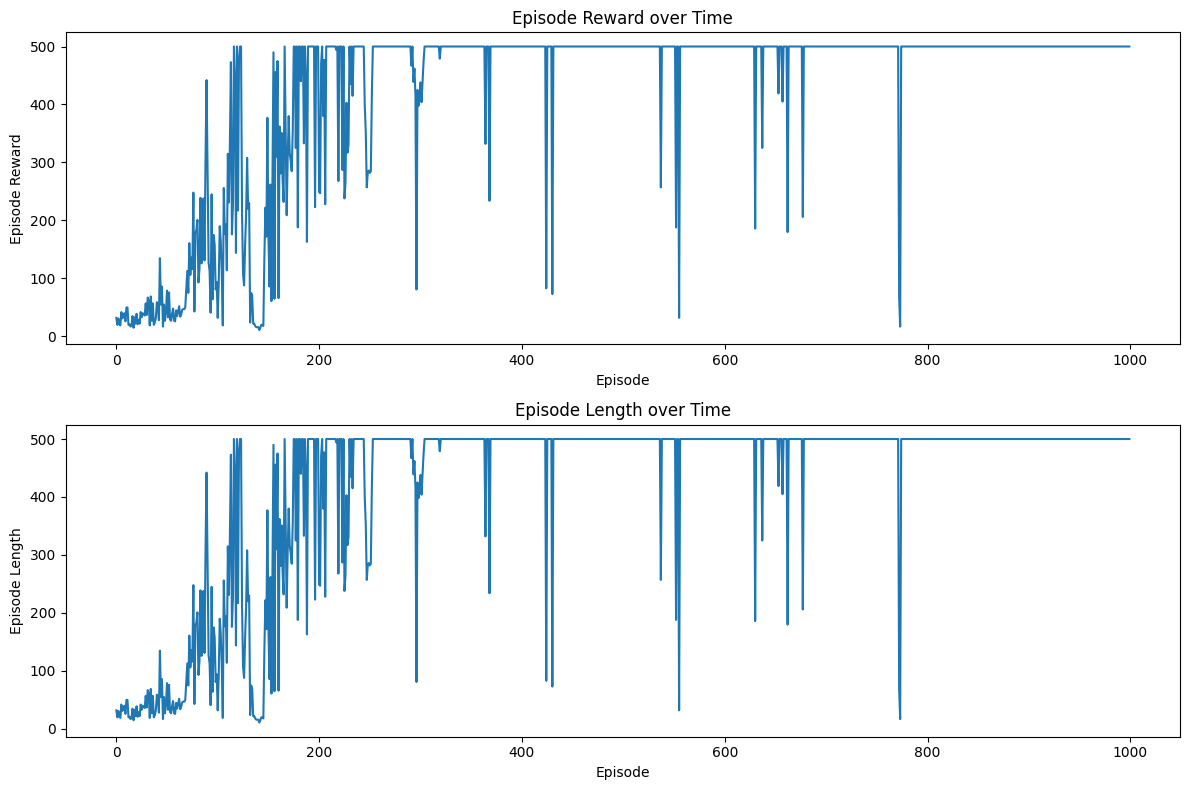

In [51]:

def plot_results(rewards, lengths, smoothing_window=100):
    # Compute rolling mean of rewards and lengths

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(12,8))

    # Plot rewards
    axs[0].plot(rewards)
    axs[0].set_title('Episode Reward over Time'.format(smoothing_window))
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Episode Reward')

    # Plot episode lengths
    axs[1].plot(lengths)
    axs[1].set_title('Episode Length over Time'.format(smoothing_window))
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Episode Length')

    # Show plots
    plt.tight_layout()
    plt.show()

plot_results(returns, lengths)
